# CEM Workflow Notebook
### Coastal Group, ESPIn 2021 Group Project
Created by Benton Franklin, Conner Lester, & Megan Gillen; 6-14-21
<br>Last Updated: 6-16-21

### Relevant References:
Ashton A., Murray B.A., Arnault O. [Formation of Coastline Features by Large-Scale Instabilities Induced by High-Angle Waves.](https://www.nature.com/articles/35104541) Nature Magazine. Volume 414. 15 November 2001. <br>
Ashton A.D., Murray A.B. [High-Angle Wave Instability and Emergent Shoreline Shapes: 1. Wave Climate Analysis and Comparisons to Nature.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005JF000422) Journal of Geophysical Research. Volume 111. 15 December 2006. <br>
Ashton A.D., Murray A.B. [High-Angle Wave Instability and Emergent Shoreline Shapes: 2. Wave Climate Analysis and Comparisons to Nature.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005JF000423) Journal of Geophysical Research. Volume 111. 15 December 2006.

### 1. Import Relevant Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import path
%matplotlib inline
import pandas as pd
from scipy import stats
from IPython.display import clear_output

from pymt.models import Cem, Waves
import buoypy as bp
import data_prep_fun as dpf
import runmodels_functions as fun

### 2. Load Shoreline Data from CoastSAT

In [2]:
# dummy shoreline that will be replaced by CoastSat shoreline
xy = np.loadtxt('Erie_spit_ESPIn.xy')
# shoreline
x=xy[:,0]
y=xy[:,1]
dx=100
dy=100

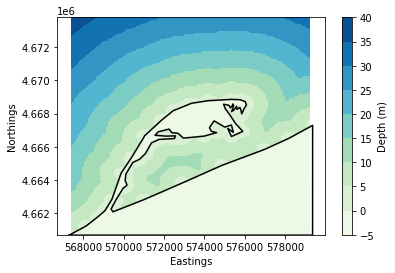

In [3]:
[xg,yg,elev] = dpf.shorelinetogrid(x,y,dx,dy,plotdata=True)
z_elev = (elev.T)

In [4]:
z_elev[z_elev==-5] = -1
z_change_elev = z_elev*-1

In [ ]:
plt.imshow(z_change_elev)
plt.colorbar()

### 3. Initialize Models from PyMT
We are using the [Coastal Evolution Model (CEM)](https://csdms.colorado.edu/wiki/Model_help:CEM) and the [WAVES](https://csdms.colorado.edu/wiki/Model_help:Waves) models. The CEM simulates morphodynamic evolution of coastlines under varying wave climates. WAVES is the model that calculates the input wave energetics used in CEM as a function of wave period (T), deep water wave height (H<sub>0</sub>), and wave angle criteria. Run the help() commands on each function and read through their documentation.

In [2]:
cem = Cem()
waves = Waves()

In [ ]:
help(cem)

In [ ]:
help(waves)

Let's look at what variables go into and come out of each model. We'll first look at ***WAVES***:

In [ ]:
waves.input_var_names

### WAVES Model Input Parameters
- `sea_surface_water_wave__height` --> Deep water wave height (H<sub>0</sub>)
- `sea_surface_water_wave__period` --> Wave period (T)
- `sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_highness_parameter` --> Proportion of high angle waves (U)
> "The variable U controls the general directional spread of the approaching waves, here split into whether waves approach from angles great than or less than the one which maximized alongshore sediment transport (approximately 45 degrees)...U varies between 0-1, controls the fraction of high-angle waves, where a value of less than 0.5 indicates wave energy predominately approaching from a low angle and a designation greater than 0.5 indicates a predominance of high-angle (unstable waves)."
> "This variable is probably the most important control on the behavior of coupled CEM-WAVES simulations using this simplified wave climate scheme. If CEM is being employed to simulate the self-organization of a coast, values of U larger than 0.5 should be used. For scenarios involving delta evolution, values less than 0.5 tend to be more reasonable (unless a local wave climate has that character). There is no specific method for deriving these terms (U and A) from natural wave climate conditions. Either A and U can be toggled to emulate a natural wave or other methods can be employed (not yet functional) where a natural wave climate can be enetered into the model." 
- `sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_asymmetry_parameter` --> Asymmetry of wave direction (A)
> "The variable A controls the directional distribution of waves, representing the fraction of waves approaching from the left or right, from the perspective of a person looking out to sea. It is designated to be a value between 0 and 1. A designation of greater than 0.5 indicates that the majority of wave energy is approaching from the left where a designation of 1.0 indicates all wave energy approaches from the left. A designation of 0.5 indicates wave energy approach is evenly distributed between the left and right. A designation of less than 0.5 indicates the majority of wave energy is approaching from the right where a designation of 0 indicates all wave energy approaches from the right."

[WAVES Documentation](https://csdms.colorado.edu/wiki/Model_help:Waves)

In [14]:
waves.output_var_names

('sea_surface_water_wave__min_of_increment_of_azimuth_angle_of_opposite_of_phase_velocity',
 'sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity',
 'sea_surface_water_wave__mean_of_increment_of_azimuth_angle_of_opposite_of_phase_velocity',
 'sea_surface_water_wave__max_of_increment_of_azimuth_angle_of_opposite_of_phase_velocity',
 'sea_surface_water_wave__height',
 'sea_surface_water_wave__period')

### WAVES Model Output Parameters
- `sea_surface_water_wave__min_of_increment_of_azimuth_angle_of_opposite_of_phase_velocity` --> Min wave refraction angle ($\alpha$)
- `sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity` --> Wave refraction angle ($\alpha$)
- `sea_surface_water_wave__mean_of_increment_of_azimuth_angle_of_opposite_of_phase_velocity` --> Mean wave refraction angle ($\alpha$)
- `sea_surface_water_wave__max_of_increment_of_azimuth_angle_of_opposite_of_phase_velocity` --> Max wave refraction angle ($\alpha$)
- `sea_surface_water_wave__height` --> Wave period (T)
- `sea_surface_water_wave__period` --> Deep water wave height (H<sub>0</sub>)

[WAVES Documentation](https://csdms.colorado.edu/wiki/Model_help:Waves)

Now, let's look at ***CEM***:

In [ ]:
cem.input_var_names

### CEM Input Parameters
- `sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity` --> Wave refraction angle ($\alpha$)
- `land_surface_water_sediment~bedload__mass_flow_rate` --> Riverine sediment load (Q<sub>s</sub>)
- `sea_surface_water_wave__period` --> Wave period (T)
- `sea_surface_water_wave__height` --> Wave height (H)
- `land_surface__elevation` --> Land elevation (L)
- `model__time_step` --> Time step for model runs (dt)

[CEM Documentation](https://csdms.colorado.edu/wiki/Model_help:CEM)

In [15]:
cem.output_var_names

('basin_outlet~coastal_center__x_coordinate',
 'basin_outlet~coastal_water_sediment~bedload__mass_flow_rate',
 'land_surface__elevation',
 'sea_water__depth',
 'basin_outlet~coastal_center__y_coordinate',
 'model__time_step')

### CEM Output Parameters
- `basin_outlet~coastal_center__x_coordinate` --> Riverine outlet longitude
- `basin_outlet~coastal_water_sediment~bedload__mass_flow_rate` --> Coastal sediment load (Q<sub>s c</sub>)
- `land_surface__elevation` --> Land elevation (L)
- `sea_water__depth` --> Water depth (Z)
- `basin_outlet~coastal_center__y_coordinate` --> Riverine outlet latitude
- `model__time_step` --> Time step for model runs (dt)

[CEM Documentation](https://csdms.colorado.edu/wiki/Model_help:CEM)

Below we reassign the long variable names to simple characters. Saves us typing in the future! See above for documentation on what each variable represents.

In [3]:
H0 = 'sea_surface_water_wave__height'
T = 'sea_surface_water_wave__period'
U = 'sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_highness_parameter'
A = 'sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_asymmetry_parameter'
alpha = 'sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity'
Qs = 'land_surface_water_sediment~bedload__mass_flow_rate'
Z = 'sea_water__depth'
L = 'land_surface__elevation'
dt = 'model__time_step'

Here we are creating a _dictionary_ to assign value to our various input parameters for both the CEM and WAVES models. Defining CEM's parameter values this way facilitates transparency and easy manipulation of the variables. This dictionary will then be passed into the **inititialize_models** function which sets up our models.

In [4]:
params = {
    
    ## CEM 
    'grid_spacing'    : 200,
    'shelf_slope'     : 0.001,
    'shoreface_depth' : 10,
    'shoreface_slope' : 0.01,
    
    ##WAVES
    'sea_surface_water_wave__height' : 1.5,
    'sea_surface_water_wave__period' : 7,
    'sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_highness_parameter': 0.8,
    'sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_asymmetry_parameter': 0.3
    
}

In the CEM, cells can either be water or land. Land cells will have a uniform height that is greater than the water depth. They will only be affected by the coastal processes of _alongshore sediment transport_ and _wave action. Inland cells will not be affected. Water cells will have a set bathymetry that will respond to sediment supply and wave action. The model calculates the bathymetry through the inner shelf slope (`shelf_slope`), depth at which the shoreface ends (`shoreface_depth`), and the shoreface slope (`shoreface_slope`).

In [ ]:
fun.intitialize_models(params,-z_change_elev,cem,waves)

We'll use the **plot_coast** function to visualize our input shoreline.

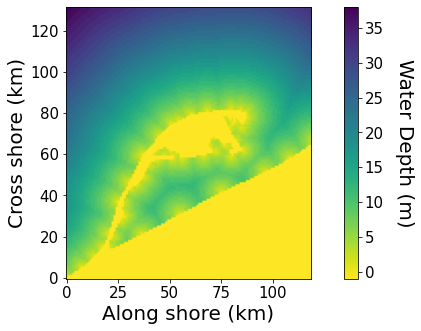

In [13]:
fun.plot_coast(-z_change_elev)

In [5]:
syn_shoreline = np.genfromtxt('SyntheticShorelineV2.csv', delimiter=',')

In [6]:
fun.intitialize_models(params,syn_shoreline,cem,waves)

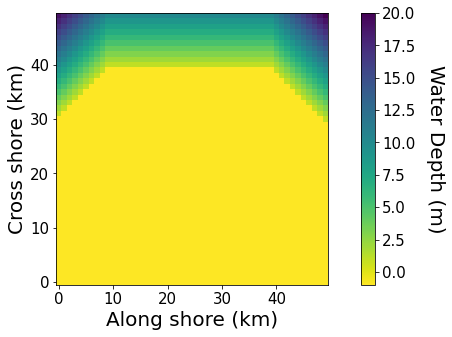

In [7]:
fun.plot_coast(syn_shoreline)

The `run_model_loop function` will run the CEM and can display an animation of the evolving shoreline. The first input expresses the model run time (in days). The function displays an animation by default but you can set `animate=False` to decrease model computation time.

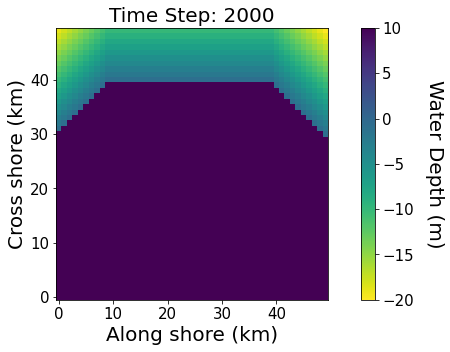

In [9]:
fun.run_model_loop(3000,syn_shoreline,cem,waves)

Congratulations! We just ran the CEM on a real coastline input. Let's compare our results to see how our models works with the CoastSAT data.

In [9]:
def plot_coast(z,model_time):
    fig,ax = plt.subplots(figsize=(12,5))
    im = ax.imshow(z, origin='lower', cmap='viridis_r')
    cb = fig.colorbar(im,ax=ax)
    cb.ax.set_ylabel('Water Depth (m)',fontsize=20,rotation=-90, labelpad=30)
    cb.ax.tick_params('y',labelsize=15)
    ax.set_xlabel('Along shore (km)',fontsize=20)
    ax.set_ylabel('Cross shore (km)',fontsize=20)
    ax.tick_params('both',labelsize=15)
    plt.title('Coastline after ' + str(int(model_time)/365) + ' years', fontsize=25)

In [9]:
def update_animate(time,z,update_period=100):
        if time%update_period == 0:
            clear_output(wait=True)
            cem.get_value(Z, out=z)
            plot_coast(z)
            plt.title('Time Step: '+ str(time),fontsize=20)
            plt.show()

In [8]:
def run_model_loop(Number_Iterations, z ,animate=True):
    
    for time in range(Number_Iterations):
        waves.update()
        angle = waves.get_value(alpha)
        cem.set_value(alpha, angle)
        #H = waves.get_value(H0)
        #cem.set_value(H0,H)
        #period = waves.get_value(T)
        #cem.set_value(T,period)
        #cem.set_value(Qs, qs)
        cem.update()
        if animate:
            update_animate(time,z)

        else:
            clear_output(wait=True)
            print('Time Step: ',time, ' days')

In [10]:
z_syn = np.empty(cem.grid_shape(cem.var_grid(Z)))
cem.get_value(Z, out=z_syn);

In [ ]:
run_model_loop(1000,z_syn)